Notre problème est : 

\begin{align*}
\ \ min_{X,u} \ &   \alpha_{0} T + \alpha_{1} \int_{0}^{T}u_{1}^2 dt + \alpha_{2} \int_{0}^{T}u_{2}^2 dt + \alpha_{3} \int_{0}^{T}u_{3}^2 dt    \\
s.c \ & \dot{x} = cos(\theta)v_{avant} - sin(\theta)v_{orth} \\
& \dot{y} = sin(\theta)v_{avant} + cos(\theta)v_{orth}  \\
& \dot{\theta} = w  \\
& \dot{v}_{avant} = u_1  \\
& \dot{w} = u_2  \\
& \dot{v}_{orth} = u_3  \\
& X(0) = X_0  \ \ et \ \  X(T) = X_{final}
\end{align*}

#### Notation :
$ \Delta t = \frac{T}{n}  $

$ x[i]  : = x(i \Delta t )   \ \forall i \in \{1,...,n \} $   

#### Remarque : 
On va approché notre intégrale par la méthode des triangles.

Prenons une subdivision de notre interval [0,T] en n sous intervalle. Nous allons transformer notre problème continue en un problème discret et de plus on va transformer nos équations diférentielle par un dévéloppement limité. 

Par exemple $ \frac{x[i+1]+x[i]}{\Delta t} $  qui est une approximation de $ \dot{x}[i]  \ \ (donc \ \ \dot{x}[i] := \frac{x[i+1]+x[i]}{\Delta t} $)



Soit $ \Delta t = \frac{T}{n}  $
\begin{align*}
(2)  \ \  \ min_{X(i),u(i)} \ &   \Delta t  \sum_{i=1}^{n} ( \alpha_{0} + \alpha_{1} u_{1}^2[i]+ \alpha_{2} u_{2}^2[i] + \alpha_{3}u_{3}^2[i]  )   \\
s.c \ &  \forall i \in \{1,...,n \}  \\
& x[i+1] = x[i] + \Delta t(cos(\theta[i])v_{1}[i] - sin(\theta[i])v_{2}[i]) \\
& y[i+1] = y[i] + \Delta t(sin(\theta[i])v_{1}[i] + cos(\theta[i])v_{2}[i])  \\
& \theta[i+1] = \theta[i] + \Delta t (w[i])  \\
& u_1[i] = \frac{v_{1}[i+1] - v_{1}[i] }{ \Delta t}  \\
& u_2[i] = \frac{w[i+1] - w[i]}{\Delta t}   \\
& u_3[i] = \frac{v_{2}[i+1] - v_{2}[i] }{\Delta t }  \\
& X[0] = X_0  \ \ et \ \  X[T] = X_{final}
\end{align*}

#### REMARQUE :  
Si un poids $α_i$ est grand, le terme correspondant a un  effet important sur la somme globale et donc est plus susceptible d’être réduit  dans le contexte global. Si $α_i$ est petit (ou égal à zéro), le terme a peu  (ou pas) d’influence sur la fonction objective et les quantités peuvent devenir  grandes sans faire beaucoup de mal. 

In [1]:
import numpy as np 
import matplotlib.pyplot as plt
import random as random
%matplotlib inline
from casadi import *


In [2]:
def distance (x,y, eps):
    if x-y > 0 :
        return eps
    else :
        return -eps

## DOC  $ (Contrôle\ optimal\ direct)$

In [3]:
n = 500
T = 2.5
taux = T/n

Times = np.linspace(0, T, n)

#### Exemple 1 

In [4]:
alpha1 = 0.499
alpha2 = 0.206
alpha3 = 0.295

In [5]:
x0 = -1.5
y0 = 1.2
theta0 = pi

xf = 0
yf = 0
thetaf = 0

In [6]:
## variable de position
x = SX.sym('x', n )
y = SX.sym('y', n )
theta = SX.sym('theta', n )

## variable de vitesse 
v1 = SX.sym('v1', n )
v2 = SX.sym('v2', n )
w = SX.sym('w', n )


## variable de accélération 
u1 = SX.sym('u1', n )
u2 = SX.sym('u2', n )
u3 = SX.sym('u3', n )


#### Fonctions utile

In [7]:
f= Function('f',[x],[x[1:]])

p =vertcat(v1[1:],0)
g = Function ('g',[v1],[p])

In [8]:
phi = Function ('phi', [u1,u2,u3], [ taux*( alpha1 * dot(u1,u1 ) + alpha2 * dot(u2 ,u2 ) + alpha3 * dot(u3 ,u3))]) 

In [9]:
opti = casadi.Opti()   # cette fonction nous permet de trouver la solution de problème

## les positions
x = opti.variable(n)
y = opti.variable(n)
theta = opti.variable(n)

## les vitesses 
v1 = opti.variable(n)        ## vitesse latérale
v2 = opti.variable(n)        ## vitesse orthogonal
w = opti.variable(n)         ## vitesse angulaire


## les accélération 
u1 = opti.variable(n)        ## accélération latérale
u3 = opti.variable(n)        ## accélération orthogonal
u2 = opti.variable(n)        ## accélération angulaire


opti.minimize(  taux*(alpha1 * dot(u1,u1) + alpha2 * dot(u2,u2 ) + alpha3 * dot( u3 ,u3 ) ) )    # ma fonction objetion

    # mes fonctions de contrainte d'égalité:

    ## pour les condition initial
opti.subject_to( x[0] == x0)        
opti.subject_to( y[0] == y0)
opti.subject_to( theta[0] == theta0)

    ## pour les contraintes d'égaliter
opti.subject_to( x[1:] == x[:n-1]+taux*(cos(theta[:n-1])*v1[:n-1] - sin(theta[:n-1])*v2[:n-1]) )
opti.subject_to( y[1:] == y[:n-1]+taux*(sin(theta[:n-1])*v1[:n-1] + cos(theta[:n-1])*v2[:n-1]) )
opti.subject_to( theta[1:] == theta[:n-1] + taux*w[:n-1] )
opti.subject_to( (g(v1)-v1)/taux  == u1 )
opti.subject_to( (g(w)-w)/taux  == u2 )
opti.subject_to( (g(v2)-v2)/taux  == u3 )
    

    ## pour les conditions finales
opti.subject_to( x[-1]==xf)
opti.subject_to( y[-1]==yf)
opti.subject_to( theta[-1]==thetaf)


opti.solver('ipopt')      # suivant la méthode de KKT

sol = opti.solve()



******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit https://github.com/coin-or/Ipopt
******************************************************************************

This is Ipopt version 3.14.4, running with linear solver MUMPS 5.2.1.

Number of nonzeros in equality constraint Jacobian...:    10990
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:     2997

Total number of variables............................:     4500
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:     3003
Total number of inequality co

In [10]:
U1_1 = sol.value(u1)
U2_1 = sol.value(u2)
U3_1 = sol.value(u3)
V1_1 = sol.value(v1)
W_1 = sol.value(w)
V2_1 = sol.value(v2)
X_1 = sol.value(x)
Y_1 = sol.value(y)
THETA_1 = sol.value(theta)

In [11]:
F = np.zeros(n)

for i in range (n):
    F[i] = phi(U1_1[i], U2_1[i], U3_1[i])

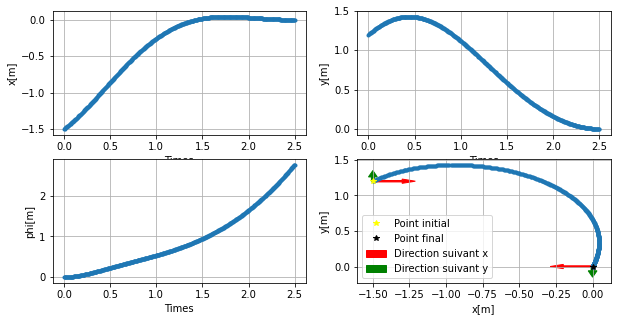

In [12]:
plt.subplots(figsize=(10, 5))

plt.subplot(2, 2, 1) 
plt.plot (Times,X_1 , '.')
plt.xlabel('Times')
plt.ylabel('x[m]')
plt.grid(True)

plt.subplot(2, 2, 2) 
plt.plot (Times,Y_1 , '.')
plt.xlabel('Times')
plt.ylabel('y[m]')
plt.grid(True)

plt.subplot(2, 2, 3) 
plt.plot (Times,F , '.')
plt.xlabel('Times')
plt.ylabel('phi[m]')
plt.grid(True)

plt.subplot(2, 2, 4) 
plt.plot (X_1,Y_1 , '.')
plt.plot(x0,y0, '*', label = 'Point initial', color = 'yellow')
plt.plot(xf,yf, '*', label = 'Point final', color = 'black')
plt.arrow(X_1[0], Y_1[0], distance(X_1[1],X_1[0], 0.2),0, width = 0.02 , color = 'red', label = "Direction suivant x")
plt.arrow(X_1[0], Y_1[0], 0, distance(Y_1[1],Y_1[0],0.06), width = 0.02, color = 'green', label = "Direction suivant y")

plt.arrow(X_1[-1], Y_1[-1], distance(X_1[-1],X_1[n-2],0.2),0, width = 0.02, color = 'red' )
plt.arrow(X_1[-1], Y_1[-1], 0, distance(Y_1[-1],Y_1[n-2],0.06), width = 0.02, color = 'green')


plt.xlabel('x[m]')
plt.ylabel('y[m]')
plt.grid(True)
plt.legend()

#### Exemple 2 

In [13]:
alpha1 = 0.85
alpha2 = 0.05
alpha3 = 0.1

In [14]:
x0 = -1.5
y0 = 1.2
theta0 = pi/10

xf = 0
yf = 0
thetaf = 0

In [15]:
opti = casadi.Opti()   # cette fonction nous permet de trouver la solution de problème

## les positions
x = opti.variable(n)
y = opti.variable(n)
theta = opti.variable(n)

## les vitesses 
v1 = opti.variable(n)        ## vitesse latérale
v2 = opti.variable(n)        ## vitesse orthogonal
w = opti.variable(n)         ## vitesse angulaire


## les accélération 
u1 = opti.variable(n)        ## accélération latérale
u3 = opti.variable(n)        ## accélération orthogonal
u2 = opti.variable(n)        ## accélération angulaire


opti.minimize(  taux*(alpha1 * dot(u1,u1) + alpha2 * dot(u2,u2 ) + alpha3 * dot( u3 ,u3 ) ) )    # ma fonction objetion

    # mes fonctions de contrainte d'égalité:

    ## pour les condition initial
opti.subject_to( x[0] == x0)        
opti.subject_to( y[0] == y0)
opti.subject_to( theta[0] == theta0)

    ## pour les contraintes d'égaliter
opti.subject_to( x[1:] == x[:n-1]+taux*(cos(theta[:n-1])*v1[:n-1] - sin(theta[:n-1])*v2[:n-1]) )
opti.subject_to( y[1:] == y[:n-1]+taux*(sin(theta[:n-1])*v1[:n-1] + cos(theta[:n-1])*v2[:n-1]) )
opti.subject_to( theta[1:] == theta[:n-1] + taux*w[:n-1] )
opti.subject_to( (g(v1)-v1)/taux  == u1 )
opti.subject_to( (g(w)-w)/taux  == u2 )
opti.subject_to( (g(v2)-v2)/taux  == u3 )
    

    ## pour les conditions finales
opti.subject_to( x[-1]==xf)
opti.subject_to( y[-1]==yf)
opti.subject_to( theta[-1]==thetaf)


opti.solver('ipopt')      # suivant la méthode de KKT

sol = opti.solve()


This is Ipopt version 3.14.4, running with linear solver MUMPS 5.2.1.

Number of nonzeros in equality constraint Jacobian...:    10990
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:     2997

Total number of variables............................:     4500
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:     3003
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  0.0000000e+00 1.50e+00 0.00e+00  -1.0 0.00e+00    -  0.00e+00 0.00e+00  

In [16]:
U1_2 = sol.value(u1)
U2_2 = sol.value(u2)
U3_2 = sol.value(u3)
V1_2 = sol.value(v1)
W_2 = sol.value(w)
V2_2 = sol.value(v2)
X_2 = sol.value(x)
Y_2 = sol.value(y)
THETA_2 = sol.value(theta)

F = np.zeros(n)

for i in range (n):
    F[i] = phi(V1_2[i], W_2[i], V2_2[i])

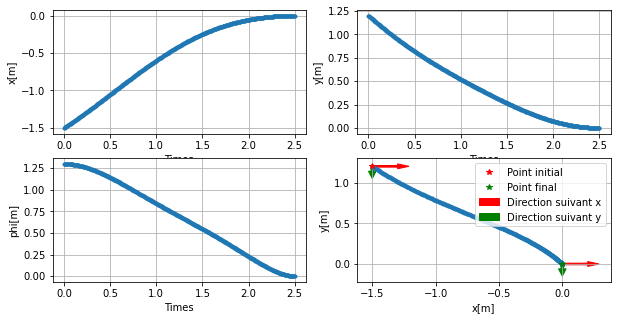

In [17]:
plt.subplots(figsize=(10, 5))

plt.subplot(2, 2, 1) 
plt.plot (Times,X_2 , '.')
plt.xlabel('Times')
plt.ylabel('x[m]')
plt.grid(True)

plt.subplot(2, 2, 2) 
plt.plot (Times,Y_2 , '.')
plt.xlabel('Times')
plt.ylabel('y[m]')
plt.grid(True)

plt.subplot(2, 2, 3) 
plt.plot (Times,F , '.')
plt.xlabel('Times')
plt.ylabel('phi[m]')
plt.grid(True)

plt.subplot(2, 2, 4) 
plt.plot (X_2,Y_2 , '.')
plt.plot(x0,y0, '*', label = 'Point initial', color = 'red')
plt.plot(xf,yf, '*', label = 'Point final', color = 'green')

plt.arrow(X_2[0], Y_2[0], distance(X_2[1],X_2[0], 0.2),0, width = 0.02 , color = 'red', label = "Direction suivant x")
plt.arrow(X_2[0], Y_2[0], 0, distance(Y_2[1],Y_2[0],0.06), width = 0.02, color = 'green', label = "Direction suivant y")

plt.arrow(X_2[-1], Y_2[-1], distance(X_2[-1],X_2[n-2],0.2),0, width = 0.02, color = 'red' )
plt.arrow(X_2[-1], Y_2[-1], 0, distance(Y_2[-1],Y_2[n-2],0.06), width = 0.02, color = 'green')


plt.xlabel('x[m]')
plt.ylabel('y[m]')
plt.grid(True)
plt.legend()

## IOC $(Contrôle\ optimal\ inverse)$

In [18]:
xi = SX.sym('xi',1)                   
yi = SX.sym('yi',1)                
thetai = SX.sym('thetai',1)


xf = SX.sym('xf',1)
yf = SX.sym('yf',1)
thetaf = SX.sym('thetaf',1)

### Pour les trois première contrainte.

In [19]:
alpha1 = SX.sym('alpha1',1)
alpha2 = SX.sym('alpha2',1)
alpha3 = SX.sym('alpha3',1)

## Position
x=SX.sym('x',n)
x_prime = SX.sym('x_prime', n+1)
x_prime[0] = x[0]
x_prime[1:] =x


y=SX.sym('y',n)
y_prime = SX.sym('y_prime', n+1)
y_prime[0] = y[0]
y_prime[1:] =y

theta=SX.sym('theta',n)
theta_prime = SX.sym('theta_prime', n+1)
theta_prime[0] = theta[0]
theta_prime[1:] =theta


## Vitesse
v1=SX.sym('v1',n)  
v1_prime = SX.sym('v1_prime', n+1)
v1_prime[0] = 0
v1_prime[n] = 0
v1_prime[1:n] =v1[0:n-1]

v1_prime_1 = SX.sym('v1_prime_1', n+1)
v1_prime_1[0] = v1[0]
v1_prime_1[1:] =v1


v2=SX.sym('v2',n)  
v2_prime = SX.sym('v2_prime', n+1)
v2_prime[0] = 0
v2_prime[n] = 0
v2_prime[1:n] =v2[0:n-1]

v2_prime_1 = SX.sym('v2_prime_1', n+1)
v2_prime_1[0] = v2[0]
v2_prime_1[1:] =v2


w=SX.sym('w',n)  
w_prime = SX.sym('w_prime', n+1)
w_prime[0] = 0
w_prime[n] = 0
w_prime[1:n] =w[0:n-1]

w_prime_1 = SX.sym('w_prime_1', n+1)
w_prime_1[0] = w[0]
w_prime_1[1:] =w


## Accélération 

u1=SX.sym('u1',n)  
u1_prime = SX.sym('u1_prime', n+1)
u1_prime[0] = 0
u1_prime[n] = 0
u1_prime[1:n] = u1[0:n-1]

u2=SX.sym('u2',n)  
u2_prime = SX.sym('u2_prime', n+1)
u2_prime[0] = 0
u2_prime[n] = 0
u2_prime[1:n] = u2[0:n-1]

u3=SX.sym('u3',n)  
u3_prime = SX.sym('u3_prime', n+1)
u3_prime[0] = 0
u3_prime[n] = 0
u3_prime[1:n] = u3[0:n-1]

Lambda = SX.sym('Lambda',n+1, 6)

In [20]:
p1=vertcat(xi,x_prime[2:],xf)   # Je définis un nouveau vecteur suivant x1 en prenant les n-1 dernières valeurs 
                               #  et la nième valeur vaut x1f
h= Function('h',[x, xi, xf],[p1])

p2=vertcat(0, v1)   
K = Function('K', [v1], [p2])


In [21]:
Y1_K = (x_prime+taux*(v1_prime*cos(theta_prime) - v2_prime*sin(theta_prime)) - h(x, xi,xf))
Y2_K = (y_prime+taux*(v1_prime*sin(theta_prime) + v2_prime*cos(theta_prime)) - h(y, yi,yf)) 
Y3_K = (theta_prime+taux*w_prime - h(theta, thetai,thetaf))

U1 = (g(v1)-v1)/taux - u1
U2 = (g(w)-w)/taux  - u2
U3 = (g(v2)-v2)/taux  - u3 

Y4_K = K(U1) 
Y5_K = K(U2)
Y6_K = K(U3)


Y_K = SX.sym('Y_K',n+1 , 6)        ## notre contrainte

for i in range (0,n+1):
    Y_K[i,0]= Y1_K[i]
    Y_K[i,1]= Y2_K[i]
    Y_K[i,2]= Y3_K[i]       
    Y_K[i,3]= Y4_K[i]       
    Y_K[i,4]= Y5_K[i]       
    Y_K[i,5]= Y6_K[i]       
    
## notre terme qui est relié a la contrainte.
G_lambda = 0

for i in range (n+1):
    G_lambda += dot(Y_K[i,:], Lambda[i,:])

In [22]:
F_val_K =  taux*( alpha1 * dot(u1,u1) + alpha2 * dot(u2,u2) + alpha3 * dot(u3,u3))

## le Lagrangien 
L_val_K = F_val_K + G_lambda

In [23]:
grad_L_K = SX.zeros(9, n)
for i in range (n):
    grad_L_K[0,i]= jacobian(L_val_K, v1[i])
    grad_L_K[1,i]= jacobian(L_val_K, w[i])
    grad_L_K[2,i]= jacobian(L_val_K, v2[i])
    grad_L_K[3,i]= jacobian(L_val_K, x[i])
    grad_L_K[4,i]= jacobian(L_val_K, y[i])
    grad_L_K[5,i]= jacobian(L_val_K, theta[i])
    grad_L_K[6,i]= jacobian(L_val_K, u1[i])
    grad_L_K[7,i]= jacobian(L_val_K, u2[i])
    grad_L_K[8,i]= jacobian(L_val_K, u3[i])
    
    
    
R_K = Function ('R_K', [u1,u2,u3,v1,w,v2,x,y,theta, Lambda, alpha1, alpha2, alpha3 ,xi,yi,thetai, xf,yf,thetaf  ], [dot(grad_L_K,grad_L_K)])
    

###  Exemple 1

In [24]:
x0 = -1.5
y0 = 1.2
theta0 = pi

xf = 0
yf = 0
thetaf = 0

In [25]:
opti = casadi.Opti()   # cette fonction nous permet de trouver la solution de problème

alpha1 = opti.variable()
alpha2 = opti.variable()
alpha3 = opti.variable()
Lambda = opti.variable(n+1,6)
    
opti.minimize( R_K(U1_1,U2_1,U3_1,V1_1,W_1,V2_1,X_1,Y_1,THETA_1, Lambda, alpha1, alpha2, alpha3, x0,y0,theta0, xf,yf,thetaf  )) 

opti.subject_to( 0 <= alpha1)
#opti.subject_to( 1 >= alpha1)

opti.subject_to( 0 <= alpha2 )
#opti.subject_to( 1 >= alpha2)


opti.subject_to( 0 <= alpha3 )
#opti.subject_to( 1 >= alpha3)


opti.subject_to(  alpha1 + alpha2 + alpha3 == 1)



opti.solver('ipopt')    

sol = opti.solve()

This is Ipopt version 3.14.4, running with linear solver MUMPS 5.2.1.

Number of nonzeros in equality constraint Jacobian...:        3
Number of nonzeros in inequality constraint Jacobian.:        3
Number of nonzeros in Lagrangian Hessian.............:    14983

Total number of variables............................:     3009
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:        1
Total number of inequality constraints...............:        3
        inequality constraints with only lower bounds:        3
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  0.0000000e+00 1.00e+00 0.00e+00  -1.0 0.00e+00    -  0.00e+00 0.00e+00  

In [26]:
print(sol.value(alpha1))
print(sol.value(alpha2))
print(sol.value(alpha3))

0.49898211331374226
0.20602921128306265
0.29498867540319507


#### Exemple 2

In [27]:
x0 = -1.5
y0 = 1.2
theta0 = pi/10

xf = 0
yf = 0
thetaf = 0

In [28]:
opti = casadi.Opti()   # cette fonction nous permet de trouver la solution de problème


alpha1 = opti.variable()
alpha2 = opti.variable()
alpha3 = opti.variable()


Lambda = opti.variable(n+1,6)

opti.minimize( R_K(U1_2, U2_2, U3_2,V1_2,W_2,V2_2,X_2,Y_2,THETA_2, Lambda, alpha1, alpha2, alpha3,  x0,y0,theta0, xf,yf,thetaf )) 

opti.subject_to( 0 <= alpha1)
#opti.subject_to( 1 >= alpha1)

opti.subject_to( 0 <= alpha2 )
#opti.subject_to( 1 >= alpha2)


opti.subject_to( 0 <= alpha3 )
#opti.subject_to( 1 >= alpha3)


opti.subject_to(  alpha1 + alpha2 + alpha3 == 1)



opti.solver('ipopt')    

sol = opti.solve()

This is Ipopt version 3.14.4, running with linear solver MUMPS 5.2.1.

Number of nonzeros in equality constraint Jacobian...:        3
Number of nonzeros in inequality constraint Jacobian.:        3
Number of nonzeros in Lagrangian Hessian.............:    14983

Total number of variables............................:     3009
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:        1
Total number of inequality constraints...............:        3
        inequality constraints with only lower bounds:        3
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  0.0000000e+00 1.00e+00 0.00e+00  -1.0 0.00e+00    -  0.00e+00 0.00e+00  

In [29]:
print(sol.value(alpha1))
print(sol.value(alpha2))
print(sol.value(alpha3))

0.849984790435448
0.05000174674448977
0.10001346282006238
